In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

plt.style.use('ggplot')
%matplotlib inline

x_train = pd.read_csv('data/x_train_norm.csv', sep=';', na_values='?')
x_test = pd.read_csv('data/x_test_norm.csv', sep=';', na_values='?')
y_train = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]



# import scipy as sp
# def logloss(act, pred):
#     epsilon = 1e-15
#     pred = sp.maximum(epsilon, pred)
#     pred = sp.minimum(1-epsilon, pred)
#     ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
#     ll = ll * -1.0/len(act)
#     return ll

# def scorer_logloss(estimator, X, y):
#     return logloss(y, estimator.predict_proba(X)[:,1])

def scorer_logloss(estimator, X, y):
    return log_loss(y, estimator.predict_proba(X)) # аналогично этому: estimator.predict_proba(X)[:,1]

def revert_scorer_logloss(estimator, X, y):
    return -1 * scorer_logloss(estimator, X, y)

In [10]:
classifier = GradientBoostingClassifier(n_estimators=100, random_state=11)
crossed = cross_val_score(classifier, x_train, y_train, scoring=scorer_logloss, n_jobs=3)

print np.mean(crossed), crossed

0.383845648674 [ 0.3850577   0.3795993   0.38687994]


Получили классификатор лучше всех педыдущих!

In [12]:
n_estimators_array = np.concatenate(([1],
                                     range(5,90,5),
                                     range(90,110),
                                     range(110,200,5),
                                     range(200,1300, 100)))

classifier = GradientBoostingClassifier(random_state=11)
grid = GridSearchCV(classifier, 
                    param_grid={'n_estimators': n_estimators_array},
                    scoring=revert_scorer_logloss,
                    n_jobs=3)
grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=11,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': array([   1,    5, ..., 1100, 1200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1114b28c0>, verbose=0)

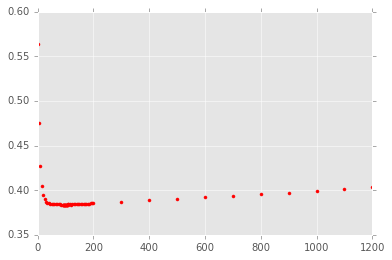

In [13]:
plt.plot(np.array(grid.cv_results_["param_n_estimators"]), grid.cv_results_["mean_test_score"] * -1, '.r')

In [15]:
print grid.best_estimator_.n_estimators, grid.best_score_ * -1

95 0.38375715888


Попробуем отправить что получилось

In [18]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_95.csv', sep=';', header=None, index=False)

# cv         = 0.38375715888
# mlbootcamp = 0.3846472

#  Отступы

Попробуем сделать следующее:
    - посчитать отступы
    - удалить их из обучающих выборок, из тестовых не удалять
    - провести повторно cv

In [19]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
classifier.fit(x_train, y_train)
predict_proba = classifier.predict_proba(x_train)

margin = np.zeros(shape=y_train.shape)
y = np.array(y_train) # pandas.core.series.Series => numpy.ndarray
idx0 = y==0
idx1 = y==1

margin[idx0] = predict_proba[idx0,0] - predict_proba[idx0,1]
margin[idx1] = predict_proba[idx1,1] - predict_proba[idx1,0]

plt.hist(margin, 50, normed=1, facecolor='green', alpha=0.75)
plt.draw()

Посчитали отступы. Классификатор 100% не уверен ни в одном из примеров

In [26]:
def cross_validation_logloss(x_train, y_train, classifier, margins, n_splits=5, margin_limit=-2):
    loglosses = []

    X = x_train
    y = y_train
    kf = KFold(n_splits=n_splits) #, shuffle=True

    i=1
    for train_index, test_index in kf.split(x_train):
        print '{}/{}'.format(i, n_splits)
        i=i+1
        
        xx_train, xx_test = x_train.loc[train_index], x_train.loc[test_index]
        yy_train, yy_test = y[train_index], y[test_index]
        margins_train = margins[train_index]

        good_margin_index = margins_train > margin_limit
        
        xx_train = xx_train[good_margin_index]
        yy_train = yy_train[good_margin_index]
        
        classifier.fit(xx_train, yy_train)
        ll = log_loss(yy_test, classifier.predict_proba(xx_test))
    
        loglosses.append(ll)
    
    print loglosses, np.mean(loglosses)
    return np.mean(loglosses)

In [31]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=-0)

1/3
2/3
3/3
[0.88424159009799297, 0.88358104347993371, 0.87645381913276221] 0.881425484237


0.88142548423689637

In [49]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
limits=np.linspace(-1,0.9,20)
lls=[]
for limit in limits:
    ll = cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=limit)
    print ll
    lls.append(ll)

1/3
2/3
3/3
[0.38350533553338101, 0.37840122892319317, 0.38956354118127695] 0.383823368546
0.383823368546
1/3
2/3
3/3
[0.38510465213234496, 0.38183470716473578, 0.3945132737637192] 0.387150877687
0.387150877687
1/3
2/3
3/3
[0.39798018468314816, 0.38973521804678307, 0.40649571576236371] 0.398070372831
0.398070372831
1/3
2/3
3/3
[0.41811387267474082, 0.40669615108278984, 0.42541523882524468] 0.416741754194
0.416741754194
1/3
2/3
3/3
[0.43256318348089912, 0.42298879827028996, 0.44130902089196644] 0.432287000881
0.432287000881
1/3
2/3
3/3
[0.45778851545915566, 0.4492466734438863, 0.46314136838210884] 0.456725519095
0.456725519095
1/3
2/3
3/3
[0.49523830827862003, 0.48463150065883109, 0.50616847591603009] 0.495346094951
0.495346094951
1/3
2/3
3/3
[0.55007873945346386, 0.54262258021531629, 0.56678794028352864] 0.553163086651
0.553163086651
1/3
2/3
3/3
[0.6236682191772307, 0.60722825023567417, 0.63014239937158811] 0.620346289595
0.620346289595
1/3
2/3
3/3
[0.73567200252825427, 0.7283032459147

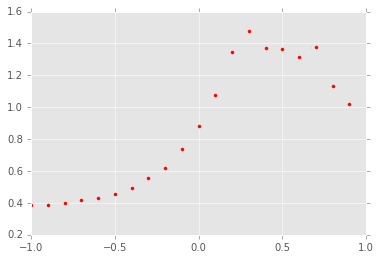

In [50]:
plt.plot(limits, np.array(lls), '.r')

Результатов нет =(

Капнем глубже и повторим поиск для разных значений n_estimators

In [64]:
n_estimators_array = np.concatenate(([1],
                                      range(5,90,5),
                                      range(90,110),
                                      range(110,200,5)))


res = []
for n_estimators in n_estimators_array:
    classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=11)
    classifier.fit(x_train, y_train)
    predict_proba = classifier.predict_proba(x_train)

    margin = np.zeros(shape=y_train.shape)
    y = np.array(y_train) # pandas.core.series.Series => numpy.ndarray
    idx0 = y==0
    idx1 = y==1

    margin[idx0] = predict_proba[idx0,0] - predict_proba[idx0,1]
    margin[idx1] = predict_proba[idx1,1] - predict_proba[idx1,0]

    classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=11)
    limits=np.linspace(-1,-0.5,20)
    lls=[]
    for limit in limits:
        ll = cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=limit)
        print ll
        lls.append(ll)
                                    
    idx = np.argmin(lls)
    
    res.append((limits[idx], lls[idx]))
                                    
print res

1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.5633787133

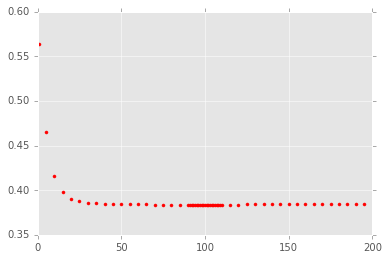

In [72]:
plt.plot(np.array(n_estimators_array), np.array([x[1] for x in res]), '.r')

In [76]:
print n_estimators_array[idx], res[idx]

92 (-1.0, 0.38376479343702136)


Улучшить не удалось

# Калибровка

In [ ]:
x_train_good, y_train_good = x_train[good_idx], y_train[good_idx]
xx_train, yy_train = x_train_good[:limit], y_train_good[:limit]
xx_valid, yy_valid = x_train_good[limit:], y_train_good[limit:]
clf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf.fit(xx_train, yy_train)
#clf_probs = clf.predict_proba(xx_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(xx_valid, yy_valid)
#sig_clf_probs = sig_clf.predict_proba(xx_test)
#sig_score = log_loss(yy_test, sig_clf_probs)

In [95]:
def cross_validation_logloss_calibrated(x_train, y_train, classifier, n_splits=5, valid_limit = 0.70):
    loglosses = []

    X = x_train
    y = y_train
    kf = KFold(n_splits=n_splits) #, shuffle=True

    i=1
    for train_index, test_index in kf.split(x_train):
        print '{}/{}'.format(i, n_splits)
        i=i+1
        
        limit_index = int((len(train_index) * valid_limit)) # Граница разбиения тренировочной выборки на тренир и валид
        valid_index = train_index[limit_index :]
        train_index = train_index[: limit_index]
        
        print limit_index
        print valid_index, train_index
        
        xx_train, xx_valid, xx_test = x_train.loc[train_index], x_train.loc[valid_index], x_train.loc[test_index]
        yy_train, yy_valid, yy_test = y[train_index], y[valid_index], y[test_index]
                
        classifier.fit(xx_train, yy_train)
        
        sig_clf = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
        sig_clf.fit(xx_valid, yy_valid)
        
        ll = log_loss(yy_test, sig_clf.predict_proba(xx_test)) #classifier.predict_proba(xx_test))    
        loglosses.append(ll)
    
    print loglosses, np.mean(loglosses)
    return np.mean(loglosses)

In [99]:
classifier = GradientBoostingClassifier(n_estimators=95,
                                        random_state=11,
                                        max_depth=5,
                                        subsample=0.5,
                                        max_features='log2')

print cross_validation_logloss_calibrated(x_train, y_train, classifier)

#0.384535979476

# n_estimators=95,
# random_state=11,
# max_depth=2,
# subsample=0.5,
# max_features='log2'
# 0.385967926516

1/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [ 5058  5059  5060 ..., 19216 19217 19218]
2/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [    0     1     2 ..., 19216 19217 19218]
3/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [    0     1     2 ..., 19216 19217 19218]
4/5
14161
[14161 14162 14163 ..., 25286 25287 25288] [    0     1     2 ..., 14158 14159 14160]
5/5
14162
[14162 14163 14164 ..., 20229 20230 20231] [    0     1     2 ..., 14159 14160 14161]
[0.392773255323008, 0.38211729979037379, 0.3794832881434374, 0.4032649753562933, 0.38047640520036774] 0.387623044763
0.387623044763


In [175]:
# Результатов не дала

In [104]:
classifier = GradientBoostingClassifier(#learning_rate=0.1,
                                        n_estimators=95,
                                        #max_features='sqrt',
                                        #subsample=0.8,
                                        random_state=11)

crossed = cross_val_score(classifier, x_train, y_train, scoring=scorer_logloss, n_jobs=3)

print np.mean(crossed), crossed

0.383757057928 [ 0.38503354  0.37952984  0.38670779]


# Решение с сайта

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [131]:
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test1,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=11,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1114b28c0>, verbose=0)

{'n_estimators': 60} -0.383094591282


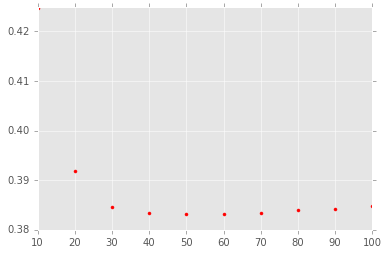

In [133]:
plt.plot(np.array(gsearch1.cv_results_["param_n_estimators"]), gsearch1.cv_results_["mean_test_score"] * -1, '.r')
print gsearch1.best_params_, gsearch1.best_score_

In [135]:
param_test2 = {'max_depth':range(5,16,2),
               'min_samples_split':range(200,1001,200)}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50, # в статье отсутствует
                                        n_estimators=60,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch2_2 = GridSearchCV(estimator = classifier,
                        param_grid = param_test2,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch2_2.fit(x_train,y_train)
gsearch2_2.best_params_, -gsearch2_2.best_score_

# в статье отсутствовал параметр min_samples_leaf=50
# без него получаем logloss = -0.38337131286907927 ({'max_depth': 5, 'min_samples_split': 600})
# а с ним 0.38279548209828834 ({'max_depth': 11, 'min_samples_split': 800}), что, естественно, лучше

({'max_depth': 11, 'min_samples_split': 800}, 0.38279548209828834)

In [136]:
# В окресности {'max_depth': 11, 'min_samples_split': 800} поищем результат получше
max_depth_opt = 11
min_samples_split_opt = 800

param_test2 = {'max_depth': range(max_depth_opt-2,max_depth_opt+3),
               'min_samples_split':range(min_samples_split_opt-200, min_samples_split_opt+201,50)}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50,
                                        n_estimators=60,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch2_3 = GridSearchCV(estimator = classifier,
                        param_grid = param_test2,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch2_3.fit(x_train,y_train)
gsearch2_3.best_params_, -gsearch2_3.best_score_

({'max_depth': 9, 'min_samples_split': 950}, 0.38212975831119084)

In [141]:
min_samples_split_opt = 950
max_depth_opt = 9

param_test3 = {'max_depth': range(max_depth_opt-2,max_depth_opt+3),
               'min_samples_split':range(min_samples_split_opt-300, min_samples_split_opt+301,50), #range(1000,2100,200),
               'min_samples_leaf':range(20,81,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=60,
                                                               #max_depth=9,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test3,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False, 
                        cv=3)
gsearch3.fit(x_train,y_train)
gsearch3.best_params_, -gsearch3.best_score_

({'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 950},
 0.38212975831119084)

max_depth и min_samples_split не изменились

In [143]:
param_test4 = {'max_features':range(2,13)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=60,
                                                               max_depth=9,
                                                               min_samples_split=950,
                                                               min_samples_leaf=50,
                                                               subsample=0.8,
                                                               random_state=11),
                        param_grid = param_test4,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False, 
                        cv=3)
gsearch4.fit(x_train,y_train)
gsearch4.best_params_, -gsearch4.best_score_

({'max_features': 3}, 0.38212975831119084)

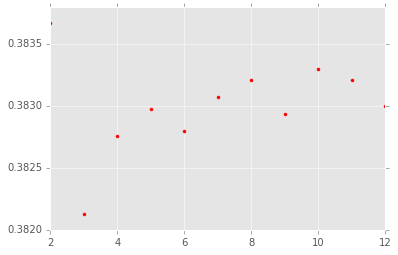

In [144]:
plt.plot(np.array(gsearch4.cv_results_["param_max_features"]), gsearch4.cv_results_["mean_test_score"] * -1, '.r')

Получили такой классификтор (с настройками дерева)
- n_estimators=60,

- max_depth=9,
- min_samples_split=950,
- min_samples_leaf=50
- max_features=3

{'n_estimators': 65} 0.382083185483


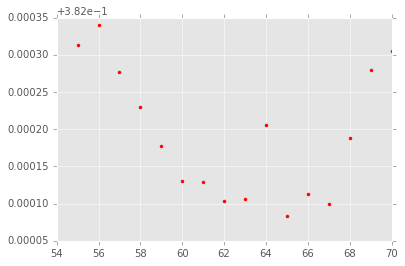

In [147]:
# уточним количество деревьев.
# изменилось с 60 до 65

param_test1 = {'n_estimators':range(55, 71)}#range(10,101,10)}
gsearch1_1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=950,
                                                               min_samples_leaf=50,
                                                               max_depth=9,
                                                               max_features=3,
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test1,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch1_1.fit(x_train, y_train)
print gsearch1_1.best_params_, -gsearch1_1.best_score_
plt.plot(np.array(gsearch1_1.cv_results_["param_n_estimators"]), gsearch1_1.cv_results_["mean_test_score"] * -1, '.r')

In [157]:
np.arange(0.5,0.9,0.1/5.0)

array([ 0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,
        0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,
        0.86,  0.88])

{'subsample': 0.80000000000000027} 0.382083185483


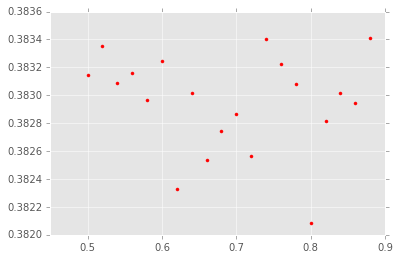

In [158]:
param_test5 = {'subsample': np.arange(0.5,0.9,0.1/5.0)}

gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                                 n_estimators=65,
                                                                 min_samples_split=950,
                                                                 min_samples_leaf=50,
                                                                 max_depth=9,
                                                                 max_features=3,
                                                                 random_state=11), 
                        param_grid = param_test5,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch5.fit(x_train, y_train)
print gsearch5.best_params_, -gsearch5.best_score_
plt.plot(np.array(gsearch5.cv_results_["param_subsample"]), gsearch5.cv_results_["mean_test_score"] * -1, '.r')

# subsample - не изменился

In [170]:
learning_rate=0.1
n_estimators=65
fractions=np.array([0.5,1,5,10,15,20]) #,25,30])

param_test6 = {'learning_rate': learning_rate/fractions,
               'n_estimators': np.array(n_estimators*fractions, dtype=int)}

gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(#learning_rate=0.1,
                                                               #  n_estimators=65,
                                                                 min_samples_split=950,
                                                                 min_samples_leaf=50,
                                                                 max_depth=9,
                                                                 max_features=3,
                                                                 subsample=0.8,
                                                                 random_state=11), 
                        param_grid = param_test6,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch6.fit(x_train, y_train)
print gsearch6.best_params_, -gsearch6.best_score_




{'n_estimators': 975, 'learning_rate': 0.0066666666666666671} 0.382005998445


In [174]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975.csv', sep=';', header=None, index=False)

# cv=0.382005998445
# mlbootcamp=0.3831089